In [229]:
#System
import os
import sys
import time

#Data Processsing
import pandas as pd
import numpy as np

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

#Machine Learning
from sklearn.metrics import classification_report , roc_auc_score , accuracy_score , confusion_matrix , precision_score , f1_score

#Graph
import networkx as nx

#Deep Learning
import torch
from torch.nn import Linear
import torch.nn.functional as F

#Geometric deep Learning
from torch_geometric.nn import GCNConv , GENConv , GraphConv , global_max_pool #GATConv
from torch_geometric.data import Data , DataLoader
from torch_geometric.utils.convert import to_networkx , from_networkx
from torch_geometric.transforms import NormalizeFeatures

#Datsets and helpers
from ogb.graphproppred import PygGraphPropPredDataset
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder

In [2]:
dataset = PygGraphPropPredDataset(name = 'ogbg-molhiv')

In [3]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: PygGraphPropPredDataset(41127):
Number of graphs: 41127
Number of features: 9
Number of classes: 2

Data(edge_attr=[40, 3], edge_index=[2, 40], x=[19, 9], y=[1, 1])
Number of nodes: 19
Number of edges: 40
Average node degree: 2.11
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [255]:
split_idx = dataset.get_idx_split() 
train_loader = DataLoader(dataset[split_idx['train']], batch_size=128, shuffle=True)
valid_loader = DataLoader(dataset[split_idx['valid']], batch_size=128, shuffle=False)
test_loader = DataLoader(dataset[split_idx['test']], batch_size=128, shuffle=False)

In [283]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(7)

        # Initialize the layers
        self.emb = AtomEncoder(hidden_channels)
        #self.conv1 = GCNConv(in_channels = hidden_channels, out_channels = hidden_channels)
        #self.conv1 = GENConv(in_channels = hidden_channels, out_channels = hidden_channels , num_layers = 3)
        self.conv1 = GraphConv(in_channels = hidden_channels, out_channels = hidden_channels)
        
        #self.conv2 = GCNConv(in_channels = hidden_channels, out_channels = hidden_channels)
        #self.conv2 = GENConv(in_channels = hidden_channels, out_channels = hidden_channels , num_layers = 3)
        self.conv2 = GraphConv(in_channels = hidden_channels, out_channels = hidden_channels)
        
        self.conv3 = GraphConv(in_channels = hidden_channels, out_channels = hidden_channels)
        
        self.out = Linear(hidden_channels, dataset.num_classes)
        self.leaky_relu = torch.nn.LeakyReLU(0.2, inplace=True)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.emb(x)
        
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = self.leaky_relu(x)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = self.leaky_relu(x)
        
        # Third Message Passing Layer
        x = self.conv3(x, edge_index)
        x = self.leaky_relu(x)
        
        #Pool embedding aat graph level
        x = global_max_pool(F.softmax(x, dim=1), batch = data.batch)
        
        # Output layer 
        x = F.dropout(x, p=0.33, training=self.training)
        x = self.out(x)
        
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (emb): AtomEncoder(
    (atom_embedding_list): ModuleList(
      (0): Embedding(119, 16)
      (1): Embedding(4, 16)
      (2): Embedding(12, 16)
      (3): Embedding(12, 16)
      (4): Embedding(10, 16)
      (5): Embedding(6, 16)
      (6): Embedding(6, 16)
      (7): Embedding(2, 16)
      (8): Embedding(2, 16)
    )
  )
  (conv1): GraphConv(16, 16)
  (conv2): GraphConv(16, 16)
  (conv3): GraphConv(16, 16)
  (out): Linear(in_features=16, out_features=2, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
)


In [284]:
# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# Initialize Optimizer
learning_rate = 0.005
#decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             #weight_decay=decay
                            )

# Define loss function (CrossEntropyLoss for Classification Problems with 
# probability distributions)
criterion = torch.nn.CrossEntropyLoss()

cuda:0


In [285]:
def train(batch):
    model.train()
    batch.to(device)
    optimizer.zero_grad() 
    # Use all data as input, because all nodes have node features
    out = model(data = batch)  
    # Only use nodes with labels available for loss calculation --> mask
    loss = criterion(out , batch.y.squeeze(1))  
    loss.backward() 
    optimizer.step()
    return out , loss

def build_evaluation_tensors(y_actual , y_pred , y_pred_proba):
    
    if y_pred != None:
        #y_pred_proba = torch.cat([y_pred_proba , out.softmax(dim = 1).squeeze(0)[:,-1]], dim = 0)
        y_pred_proba = torch.cat([y_pred_proba , out.softmax(dim = 1)], dim = 0)
        y_pred = torch.cat([y_pred , out.softmax(dim = 1).argmax(dim = 1)], dim = 0)
        y_actual = torch.cat([y_actual , batch.y.squeeze(1)] , dim = 0)
        
    else:
        #y_pred_proba = out.softmax(dim = 1).squeeze(0)[:,-1]
        y_pred_proba = out.softmax(dim = 1)
        y_pred = out.softmax(dim = 1).argmax(dim = 1)
        y_actual = batch.y.squeeze(1)
        
    return y_actual , y_pred , y_pred_proba

In [286]:
losses = []
start_time = time.time()
epoch_start_time = time.time()
total_epochs = 5
total_batches = len(train_loader)
print_every = 1000
print('Begin training')
print('total epochs : {}'.format(total_epochs))
print('total_batches : {}'.format(total_batches))
for epoch in range(0, total_epochs):
    batch_ctr = 1
    
    y_pred_proba = None
    y_pred = None 
    y_actual =  None
    
    for batch in train_loader:
        out , loss = train(batch = batch)
        losses.append(loss.item())
        
        y_actual , y_pred , y_pred_proba = build_evaluation_tensors(y_actual = y_actual
                                                                    , y_pred = y_pred
                                                                    , y_pred_proba = y_pred_proba)
        
        if batch_ctr % print_every == 0:
            print('Epoch: {}/{}, Batch: {}/{} , Loss: {} , Time : {} secs'.format(epoch + 1
                                                                                  , total_epochs 
                                                                                  , batch_ctr 
                                                                                  , total_batches 
                                                                                  , loss 
                                                                                  , round(time.time() - start_time , 0)))
            start_time = time.time()
        
        batch_ctr+=1
        
    y_actual = np.array(y_actual.detach().cpu().numpy())
    y_pred = np.array(y_pred.detach().cpu().numpy())
    y_pred_proba = np.array(y_pred_proba.detach().cpu().numpy())
    
    print('\nTRAIN SET Epoch: {}/{}, Avg Loss: {} , AUC: {}, Acc: {}, Epoch Time : {} secs'.format(epoch + 1
                                                                , total_epochs 
                                                                , sum(losses) / len(losses)
                                                                , roc_auc_score(y_true = y_actual , y_score = y_pred_proba[:,-1])
                                                                , accuracy_score(y_true = y_actual , y_pred = y_pred)                  
                                                                , round(time.time() - epoch_start_time , 0)))
    epoch_start_time = time.time()
    
    model = model.eval()

    y_pred_proba = None
    y_pred = None 
    y_actual =  None
    for batch in valid_loader:
        batch.to(device)
        out = model(data = batch)
    
        y_actual , y_pred , y_pred_proba = build_evaluation_tensors(y_actual = y_actual
                                                                    , y_pred = y_pred
                                                                    , y_pred_proba = y_pred_proba)
            
    y_actual = np.array(y_actual.detach().cpu().numpy())
    y_pred = np.array(y_pred.detach().cpu().numpy())
    y_pred_proba = np.array(y_pred_proba.detach().cpu().numpy())
    print('VALID SET Epoch: {}/{}, AUC: {}, Acc: {}\n'.format(epoch + 1
                                                                , total_epochs 
                                                                , roc_auc_score(y_true = y_actual , y_score = y_pred_proba[:,-1])
                                                                , accuracy_score(y_true = y_actual , y_pred = y_pred)))

Begin training
total epochs : 5
total_batches : 258

TRAIN SET Epoch: 1/5, Avg Loss: 0.22001719292859698 , AUC: 0.4817299902645588, Acc: 0.9558979970213671, Epoch Time : 25.0 secs
VALID SET Epoch: 1/5, AUC: 0.48018016362923766, Acc: 0.9803063457330415


TRAIN SET Epoch: 2/5, Avg Loss: 0.19543915665022624 , AUC: 0.5175475023098093, Acc: 0.9625543296556336, Epoch Time : 29.0 secs
VALID SET Epoch: 2/5, AUC: 0.5504696991965511, Acc: 0.9803063457330415


TRAIN SET Epoch: 3/5, Avg Loss: 0.18485207462957662 , AUC: 0.5550902076388357, Acc: 0.9625543296556336, Epoch Time : 25.0 secs
VALID SET Epoch: 3/5, AUC: 0.5754948069762884, Acc: 0.9803063457330415


TRAIN SET Epoch: 4/5, Avg Loss: 0.17878084439538824 , AUC: 0.5807035501758654, Acc: 0.9625543296556336, Epoch Time : 25.0 secs
VALID SET Epoch: 4/5, AUC: 0.6350186165000979, Acc: 0.9803063457330415


TRAIN SET Epoch: 5/5, Avg Loss: 0.17480867403422215 , AUC: 0.5986609590557852, Acc: 0.9625543296556336, Epoch Time : 25.0 secs
VALID SET Epoch: 5/

               precision    recall  f1-score   support

not effective       0.98      1.00      0.99      4032
    effective       0.00      0.00      0.00        81

     accuracy                           0.98      4113
    macro avg       0.49      0.50      0.50      4113
 weighted avg       0.96      0.98      0.97      4113

accuracy : 0.9803063457330415

Confusion matrix


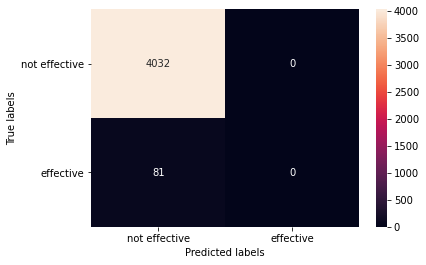


ROC AUC Curve


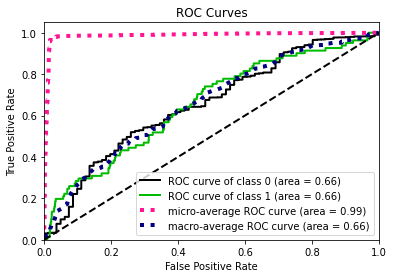

In [287]:
def my_classification_report(y_actual , y_pred , y_pred_proba = None, labels = None):
    """
    Description : 
    - This function takes precdicted and actual values and gives key classification metrics
    
    Inputs:
    1. y_actual : Array of actual labels
    2. y_pred :  Array of predicted labels
    3. y_pred_proba :  probabilities for each lables
    4. labels : labels assigned to classes
    
    Outputs:
    1. Prescision , recall, F1-Score and Accuracy metrics
    2. Plot of confusion matrix
    3. Plot of ROC AUC Curve 
    """
    
    print(classification_report(y_true = y_actual, y_pred = y_pred , target_names = labels , zero_division = 0))
    acc = accuracy_score(y_true = y_actual , y_pred = y_pred)
    print('accuracy : {}'.format(acc))
    
    print('\nConfusion matrix')
    ax = plt.subplot()
    conf_mat=confusion_matrix(y_true = y_actual, y_pred = y_pred)
    #print(conf_mat)
    sns.heatmap(data = conf_mat , annot = True , fmt  = 'd' , xticklabels = labels , yticklabels = labels)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    plt.yticks(rotation='horizontal')
    plt.show()
    
    print('\nROC AUC Curve')
    skplt.metrics.plot_roc(y_true = y_actual, y_probas = y_pred_proba)
    plt.show()
    
    
labels = ['not effective' , 'effective']
my_classification_report(y_actual = y_actual
                             , y_pred = y_pred
                             , y_pred_proba = y_pred_proba
                             , labels = labels)